# XGBoost

## Setup

In [0]:
import mlflow
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import (
    VectorAssembler, MinMaxScaler, StandardScaler, StringIndexer, OneHotEncoder, Imputer, SQLTransformer
)

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, log1p, when

# Spark SQL API
from pyspark.sql import Window, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, concat, col, row_number, monotonically_increasing_id, udf, expr, abs, least, col, approx_count_distinct, stddev, mean, min, max

from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType
from pyspark.ml.linalg import VectorUDT, SparseVector, Vectors, DenseVector
from pyspark.ml import Transformer

import pickle
import os
from functools import reduce
import numpy as np
import pyspark.pandas as ps
import matplotlib.pyplot as plt

# Hyperparameter optimization
import optuna
from optuna.pruners import MedianPruner

# Sklearn
from sklearn.model_selection import TimeSeriesSplit

#SMOTE
from imblearn.over_sampling import SMOTE

In [0]:
# set the experiment id
mlflow.set_experiment(experiment_id="59813923271508")
mlflow.autolog()


In [0]:
# Mount blob storage and grant team access
blob_container  = "261project"       # The name of your container created in https://portal.azure.com
storage_account = "261teamderm"  # The name of your Storage account created in https://portal.azure.com
secret_scope = "261teamderm"           # The name of the scope created in your local computer using the Databricks CLI
secret_key = "261key"             # The name of the secret key created in your local computer using the Databricks CLI
team_blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"  #points to the root of your team storage bucket
mids261_mount_path      = "/mnt/mids-w261" # the 261 course blob storage is mounted here.
# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
  )

In [0]:
# Spark Context
sc = spark.sparkContext
spark

In [0]:
spark = SparkSession.builder.appName('ClassifyDelaysWithXGBoost_1').getOrCreate()

# Functions

In [0]:
def cast_integers_to_double(df):
    """
    Cast all integer columns in a DataFrame to double.
    """
    integer_cols = [field.name for field in df.schema.fields if field.dataType.simpleString() == "int"]
    for col_name in integer_cols:
        df = df.withColumn(col_name, col(col_name).cast("double"))
    return df

def check_min_values(df, numerical_cols):
    # Calculate min, median, and max for each numerical column
    agg_exprs = []
    for col_name in numerical_cols:
        agg_exprs.append(min(col(col_name)).cast("double").alias(f"{col_name}_min"))
        agg_exprs.append(expr(f"percentile_approx({col_name}, 0.5)").cast("double").alias(f"{col_name}_median"))
        agg_exprs.append(max(col(col_name)).cast("double").alias(f"{col_name}_max"))

    # Aggregate the values
    agg_df = df.agg(*agg_exprs)

    # Convert the aggregated DataFrame to a pivot table format
    pivot_df = agg_df.selectExpr("stack(" + f"{len(numerical_cols)}, " + ", ".join([f"'{col_name}', {col_name}_min, {col_name}_median, {col_name}_max" for col_name in numerical_cols]) + ") as (column, min, median, max)")

    # Display the pivot table
    display(pivot_df)


def shift_to_positive(df, numerical_cols, manual=False, manual_value=None):
    # Calculate the absolute minimum value across all numerical columns
    absolute_min_value = df.select(
         least(*[col(c) for c in numerical_cols]).alias("absolute_min")
     ).agg({"absolute_min": "min"}).collect()[0][0]
 
    # If the minimum value is negative, shift all numerical    
    if manual:
        shifted_value = manual_value
        for col_name in numerical_cols:
            df = df.withColumn(col_name, col(col_name) + lit(shifted_value))
            display(f"Abs min value < 0, shifting {col_name} by {shifted_value}")
    else:
        shift = 100
        if absolute_min_value < 0:
            shifted_value = (absolute_min_value * -1) + shift
            for col_name in numerical_cols:
                df = df.withColumn(col_name, col(col_name) + lit(shifted_value))
                display(f"Abs min value < 0, shifting {col_name} by {shifted_value}")
        else:
            shifted_value = absolute_min_value + shift
            for col_name in numerical_cols:
                df = df.withColumn(col_name, col(col_name) + lit(shifted_value))
                display(f"Abs min value >= 0, shifting {col_name} by {shifted_value}")
    return df

def get_train_val_data(df, fold):
    """
    Function to filter training and validation sets
    """
    train_data = df.filter((col('split') == 'train') & (col('foldCol') == fold))
    val_data = df.filter((col('split') == 'val') & (col('foldCol') == fold))
    return train_data, val_data

def get_sampled_dataset(df, drop_constants=False):
    
    # Filter for a test dataframe using one fold and a percentage of the data stratified by the 'split' column
    fold = 0
    perc = 0.01

    # Sample and create test_df
    test_df = df.filter(col('foldCol') == fold).sampleBy('split', fractions={'train': perc, 'val': perc})

    # Total row count for relative thresholding
    total_rows = test_df.count()

    # Redefine constant_cols with relative threshold
    constant_cols = [
        c for c in numerical_cols 
        if test_df.agg(approx_count_distinct(col(c)).alias("distinct")).collect()[0]["distinct"] / total_rows < 0.10
    ]
    non_constant_numerical_cols = [
        c for c in numerical_cols 
        if test_df.agg(approx_count_distinct(col(c)).alias("distinct")).collect()[0]["distinct"] / total_rows >= 0.10
    ]

    # Filter columns for numerical and categorical cols
    test_df = test_df.select(constant_cols + non_constant_numerical_cols + categorical_cols + ['split', 'foldCol', label_col])

    if drop_constants:
        test_df = test_df.drop(*constant_cols)

    return test_df, constant_cols, non_constant_numerical_cols


# Additional pre-processing

## Read data from Blob

In [0]:
# Get data
filtered_df = spark.read.parquet(f"{team_blob_url}/data/5yr_preprocessed.parquet")

# Cast integers as doubles and drop pagerank is null rows
filtered_df = cast_integers_to_double(filtered_df)
filtered_df = filtered_df[col("pagerank").isNotNull()]

## Set columns

In [0]:
# Define feature columns
ignore_cols = ['ORIGIN', 'DEST','FL_DATE', 'CANCELLED', 'YEAR']

# Enumerate columns for ohe ("categorical"), already ohe ("ohe") and for scaling ()
need_ohe_cols = ['QUARTER', 'MONTH', 'DAY_OF_WEEK','OP_UNIQUE_CARRIER', 'DEP_TIME_BLK', 'ARR_TIME_BLK', 'DAY_OF_MONTH', 'HIST_ARR_FLT_NUM', 'HIST_DEP_FLT_NUM']
already_ohe_cols = ['ceiling_height_is_below_10000', 'ceiling_height_is_between_10000_20000', 'ceiling_height_is_above_20000', 'isHoliday', 'specWeather']
standard_scalar_cols = ['wind_direction', 'temperature', 'sea_level_pressure'] # wind, temp and pressure
min_max_cols = ['CRS_ELAPSED_TIME', 'DISTANCE', # Time and distance
                'dew_point', 'wind_speed',  # vis, dew, weather and wind
                'origin_yr_flights', 'dest_yr_flights', # origin/dest
                'HIST_ARR_DELAY', 'HIST_DEP_DELAY' # lag columns for previous flights
                ]
unscaled_cols =['visibility', 'gust_speed','pagerank']

# Consolidate
categorical_cols = need_ohe_cols + already_ohe_cols
numerical_cols = standard_scalar_cols + min_max_cols + unscaled_cols
label_col = 'DEP_DEL15'


## Shift column values below 0 to above 0

In [0]:
perform_shift = False

if perform_shift:
    # Shift values if negative values exist
    shifted_df = shift_to_positive(filtered_df, numerical_cols)

In [0]:
if perform_shift:
    # Check results of shifting - Original pre-shifting
    check_min_values(filtered_df, numerical_cols)

In [0]:
if perform_shift:
    # Check results of shifting - Post-shifting
    check_min_values(shifted_df, numerical_cols)

In [0]:
if perform_shift:
    # Display
    print(shifted_df.count())
    display(shifted_df.groupBy("foldCol", "split",label_col).count().orderBy("foldCol", "split", label_col))

# Filter for test set and run Optuna

In [0]:
# Get small sample set
if perform_shift:
    sample_df, constant_cols, non_constant_numerical_cols = get_sampled_dataset(shifted_df, drop_constants=False)
else:
    sample_df, constant_cols, non_constant_numerical_cols = get_sampled_dataset(filtered_df, drop_constants=False)

# See results
display(sample_df.groupBy("foldCol", "split",label_col).count().orderBy("foldCol", "split", label_col))
display(sample_df)
print('constant_cols:', constant_cols)
print('non_constant_numerical_cols:', non_constant_numerical_cols)


foldCol split DEP_DEL15 count 0.0 train 0.0 3224 0.0 train 1.0 2958 0.0 val 0.0 794 0.0 val 1.0 776

wind_direction temperature sea_level_pressure CRS_ELAPSED_TIME dew_point wind_speed origin_yr_flights dest_yr_flights HIST_ARR_DELAY HIST_DEP_DELAY visibility gust_speed pagerank DISTANCE QUARTER MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER DEP_TIME_BLK ARR_TIME_BLK DAY_OF_MONTH HIST_ARR_FLT_NUM HIST_DEP_FLT_NUM ceiling_height_is_below_10000 ceiling_height_is_between_10000_20000 ceiling_height_is_above_20000 isHoliday specWeather split foldCol DEP_DEL15 null 7.8 1019.9 172.0 3.9 0.0 41491.75 225885.25 -6.0 -3.0 16.093 5.0 1.705596003092729 1205.0 4.0 12.0 3.0 AA 1200-1259 1700-1759 2.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 70.0 21.7 1014.7 155.0 13.3 2.1 283891.5 221620.5 19.0 17.0 16.093 5.0 15.609224211537683 888.0 3.0 7.0 5.0 F9 1700-1759 1900-1959 3.0 2.0 1.0 1.0 0.0 0.0 1.0 0.0 train 0.0 1.0 280.0 30.0 1013.0 340.0 20.0 4.1 98233.0 201555.75 10.0 8.0 16.093 5.0 3.939528742539286 2329.0 3.0 8.0 2.0 WN 1700-1759 1900-1959 4.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 340.0 23.9 1014.4 96.0 21.1 3.6 90202.5 130755.5 -21.0 -1.0 14.484 5.0 3.192225950535472 405.0 3.0 9.0 5.0 DL 1200-1259 1300-1359 4.0 2.0 2.0 0.0 0.0 1.0 1.0 0.0 train 0.0 1.0 160.0 1.7 1026.0 73.0 0.0 2.6 9894.75 134489.5 19.0 23.0 2.816 5.0 0.6056967417776956 228.0 4.0 12.0 7.0 OO 1700-1759 1800-1859 6.0 2.0 2.0 1.0 0.0 0.0 0.0 1.0 train 0.0 1.0 160.0 25.0 1013.1 267.0 15.0 3.6 283891.5 56052.5 1.0 1.0 16.093 5.0 15.609224211537683 1739.0 3.0 8.0 5.0 AA 1700-1759 2000-2059 7.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 20.0 0.6 null 105.0 -1.1 3.1 86468.5 90202.5 -24.0 23.0 0.805 5.0 3.5915404679058067 601.0 4.0 12.0 1.0 WN 1300-1359 1600-1659 7.0 3.0 2.0 1.0 0.0 0.0 0.0 1.0 train 0.0 1.0 250.0 22.2 1005.9 85.0 18.3 7.2 86468.5 32087.0 -7.0 -2.0 16.093 5.0 3.355609154780254 402.0 2.0 6.0 1.0 WN 1400-1459 1600-1659 8.0 2.0 2.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 360.0 2.2 1014.0 111.0 -1.1 4.1 4728.0 283891.5 -10.0 1.0 16.093 5.0 0.43407505642929 557.0 2.0 4.0 4.0 EV 1100-1159 1300-1359 9.0 3.0 2.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 70.0 20.6 1017.3 100.0 16.1 5.7 126195.5 98233.0 2.0 21.0 16.093 5.0 4.736863383307768 369.0 3.0 8.0 7.0 WN 2000-2059 2200-2259 9.0 2.0 2.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 230.0 16.7 1013.5 110.0 12.8 2.6 164508.0 1180.0 4.0 38.0 16.093 5.0 6.922454630280578 587.0 3.0 7.0 5.0 OO 1600-1659 1800-1859 10.0 2.0 1.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 80.0 17.8 1015.5 134.0 -0.6 2.1 158003.5 164508.0 -1.0 0.0 16.093 5.0 6.135428124889296 651.0 4.0 12.0 4.0 OO 1900-1959 2100-2159 10.0 2.0 1.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 130.0 26.7 1012.3 190.0 19.4 4.1 283891.5 83452.75 -20.0 -5.0 16.093 5.0 15.609224211537683 1182.0 3.0 7.0 7.0 UA 0600-0659 1000-1059 12.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 320.0 5.0 1018.1 126.0 2.8 3.1 225885.25 221620.5 21.0 -1.0 16.093 5.0 12.982455541367855 641.0 4.0 12.0 2.0 OO 1200-1259 1300-1359 1.0 3.0 2.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 300.0 19.0 null 115.0 18.0 2.1 57793.75 68398.5 -13.0 -3.0 2.414 5.0 2.10076114447683 623.0 2.0 6.0 1.0 WN 1900-1959 2100-2159 1.0 2.0 1.0 1.0 0.0 0.0 0.0 1.0 train 0.0 1.0 null 1.1 1023.2 180.0 -12.2 1.5 126195.5 373483.0 -1.0 -6.0 16.093 5.0 4.226721851529252 946.0 2.0 4.0 4.0 WN 1100-1159 1400-1459 2.0 2.0 2.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 160.0 13.3 1000.8 85.0 9.4 5.1 42703.5 80349.0 -18.0 -4.0 16.093 5.0 1.6640513528072416 480.0 4.0 10.0 7.0 WN 1500-1559 1600-1659 4.0 3.0 2.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 240.0 25.6 1013.9 75.0 15.0 2.6 20259.25 47505.5 9.0 82.0 16.093 5.0 0.9286130112299066 362.0 3.0 7.0 7.0 WN 2100-2159 2200-2259 5.0 3.0 2.0 0.0 0.0 1.0 1.0 0.0 train 0.0 1.0 130.0 33.3 1018.8 163.0 22.8 2.1 123374.75 7943.5 -16.0 93.0 16.093 5.0 4.9723885394060074 972.0 3.0 8.0 3.0 B6 1900-1959 2200-2259 5.0 2.0 1.0 0.0 0.0 1.0 0.0 0.0 train 0.0 1.0 100.0 24.4 1015.6 90.0 17.8 3.1 13423.0 123374.75 51.0 59.0 16.093 5.0 0.6701688010878463 479.0 4.0 10.0 1.0 WN 1800-1859 2000-2059 5.0 2.0 1.0 1.0 0.0 0.0 0.0 0.0 train 0.0 1.0 null 23.9 1011.2 108.0 22.2 0.0 8

constant_cols: ['wind_direction', 'temperature', 'sea_level_pressure', 'CRS_ELAPSED_TIME', 'dew_point', 'wind_speed', 'origin_yr_flights', 'dest_yr_flights', 'HIST_ARR_DELAY', 'HIST_DEP_DELAY', 'visibility', 'gust_speed', 'pagerank']
non_constant_numerical_cols: ['DISTANCE']


In [0]:
from pyspark.sql.functions import col


# ======================================== Set for Testing =============================================
# Update as needed
test=False

# ===================================== Set data and n trials ==========================================

# Set df and n_trials   
if test:
    df = sample_df
    n_trials = 1
else:
    if perform_shift:
        df = shifted_df
    else:
        df = filtered_df
    n_trials = 20

# ============================= Define Objective Function + Metrics ===================================

def objective(trial):
    # Hyperparameter search
    imputation_strategy = trial.suggest_categorical("imputation_strategy", ["mean"]) # imputation
    max_depth = trial.suggest_float('max_depth', 3, 20, log=False) # max depth
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5) # learning rate
    subsample = trial.suggest_float("subsample", 0.1, 1.0) # Subsample ratio of the training instances
    n_estimators = trial.suggest_int("n_estimators", 10, 30) # num trees
    boost_type = trial.suggest_categorical("boost_type", ["gbtree", "dart"]) # boost type.
    gamma_val = trial.suggest_float("gamma", 0.0, 10.0, log=False) 
    min_child_weight = trial.suggest_float("min_child_weight",0.0, 10.0, log=False)

    # look at abbas random forest and adopt same range...

    # Apply imputer for all numerical columns
    imputer = Imputer(
        strategy=imputation_strategy,
        inputCols=numerical_cols,
        outputCols=[f"{col}_imputed" for col in numerical_cols]
    )

    indexers = [
        StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") 
        for col in categorical_cols
    ]
    encoders = [
        OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe") 
        for col in categorical_cols
    ]

    assembler = VectorAssembler(
        inputCols=[f"{col}_ohe" for col in need_ohe_cols] + already_ohe_cols + [f"{col}_imputed" for col in numerical_cols],
        outputCol="features"
    )

    model = SparkXGBClassifier(
        features_col="features", 
        label_col=label_col,
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        n_estimators=int(n_estimators),
        booster=boost_type,
        gamma=gamma_val,
        min_child_weight=min_child_weight,
    )

    pipeline = Pipeline(stages=[imputer] + indexers + encoders + [assembler, model]) 

    evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName="areaUnderROC")

    fold_metrics = {"train": [], "val": []}
    num_folds = df.select('foldCol').distinct().count()
    fold_weights = range(1, num_folds + 1)

    for fold in range(num_folds):
        train_data, val_data = get_train_val_data(df, fold)

        pipeline_model = pipeline.fit(train_data)

        # Evaluate on train and validation data
        for split_name, data in [("train", train_data), ("val", val_data)]:
            predictions = pipeline_model.transform(data)
            auc = evaluator.evaluate(predictions)

            # Compute metrics
            tp = predictions.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
            fp = predictions.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
            fn = predictions.filter((col(label_col) == 1) & (col("prediction") == 0)).count()
            tn = predictions.filter((col(label_col) == 0) & (col("prediction") == 0)).count()

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

            f1_micro = accuracy
            f1_macro = (precision + recall) / 2 if (precision + recall) > 0 else 0
            f1_weighted = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            beta = 0.5
            fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

            # Store fold metrics
            fold_metrics[split_name].append({
                "fold": fold,
                "auc": auc,
                "precision": precision,
                "recall": recall,
                "accuracy": accuracy,
                "f1_micro": f1_micro,
                "f1_macro": f1_macro,
                "f1_weighted": f1_weighted,
                "fbeta": fbeta,
                "weight": fold_weights[fold]
            })

            # Log fold-specific metrics
            for metric_name, metric_value in {
                "auc": auc, "precision": precision, "recall": recall,
                "accuracy": accuracy, "f1_micro": f1_micro, "f1_macro": f1_macro,
                "f1_weighted": f1_weighted, "fbeta": fbeta
            }.items():
                trial.set_user_attr(f"{split_name}_fold_{fold}_{metric_name}", metric_value)

    # Aggregate metrics across folds for train and val separately
    metrics_per_split = {}
    for split_name in ["train", "val"]:
        total_weight = sum(m["weight"] for m in fold_metrics[split_name])

        metrics_per_split[split_name] = {
            metric: sum(m[metric] * m["weight"] for m in fold_metrics[split_name]) / total_weight
            for metric in ["auc", "precision", "recall", "accuracy", "f1_micro", "f1_macro", "f1_weighted", "fbeta"]
        }

    # Log aggregated metrics
    for split_name, metrics in metrics_per_split.items():
        for metric_name, metric_value in metrics.items():
            trial.set_user_attr(f"{split_name}_weighted_average_{metric_name}", metric_value)

    # Store per-fold metrics for later analysis
    trial.set_user_attr("fold_metrics", fold_metrics)

    trial.report(metrics_per_split["val"]["fbeta"], step=0)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    print('Fold metrics stored in trial user attributes')
    print('val fbeta:', metrics_per_split["val"]["fbeta"])
    return metrics_per_split["val"]["fbeta"]

# ======================================== Run Optuna Study ============================================

# Create Optuna study with MedianPruner
study = optuna.create_study(direction="maximize", 
                            pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1
                                                )
                            )
study.optimize(objective, 
               n_trials=n_trials, 
               n_jobs=-1
               )


[I 2024-12-14 21:35:45,195] A new study created in memory with name: no-name-49697b8f-e112-45b7-88cb-4f6e6d9642f7
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 0.11059395583859266, 'learning_rate': 0.3795126410885817, 'max_depth': 5, 'min_child_weight': 1.6251965847470062, 'subsample': 0.665596276368819, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 27}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'gbtree', 'device': 'cpu', 'gamma': 9.724514158215744, 'learning_rate': 0.24361277415566399, 'max_depth': 9, 'min_child_weight': 3.5355958180240843, 'subsample': 0.10350995132022481, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 24}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBo

Fold metrics stored in trial user attributes
val fbeta: 0.7305668128141124


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 0.3900768422736245, 'learning_rate': 0.11709409837149838, 'max_depth': 12, 'min_child_weight': 9.98072975633081, 'subsample': 0.16936538268600038, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 19}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[I 2024-12-14 22:03:08,598] Trial 14 finished with value: 0.7333289822664355 and parameters: {'imputation_strategy': 'mean', 'max_depth': 4.026656384554728, 'learning_rate': 0.42907216220212263, 'subsample': 0.8627495317633996, 'n_estimators': 29, 'boost_type': 'gbtree', 'gamma': 3.2642060188755995, 'min_child_weight': 4.179127201707315}. Best is trial 14 with value: 0.7333289822664355.


Fold metrics stored in trial user attributes
val fbeta: 0.7333289822664355


[I 2024-12-14 22:03:13,112] Trial 15 finished with value: 0.7364064743764422 and parameters: {'imputation_strategy': 'mean', 'max_depth': 8.651681830735653, 'learning_rate': 0.18333710137002288, 'subsample': 0.6323691699849779, 'n_estimators': 22, 'boost_type': 'gbtree', 'gamma': 0.5298609055150394, 'min_child_weight': 8.31302965260073}. Best is trial 15 with value: 0.7364064743764422.


Fold metrics stored in trial user attributes
val fbeta: 0.7364064743764422


[I 2024-12-14 22:03:13,855] Trial 8 finished with value: 0.7348258753134145 and parameters: {'imputation_strategy': 'mean', 'max_depth': 9.354540036391121, 'learning_rate': 0.24361277415566399, 'subsample': 0.10350995132022481, 'n_estimators': 24, 'boost_type': 'gbtree', 'gamma': 9.724514158215744, 'min_child_weight': 3.5355958180240843}. Best is trial 15 with value: 0.7364064743764422.


Fold metrics stored in trial user attributes
val fbeta: 0.7348258753134145


[I 2024-12-14 22:03:15,571] Trial 2 finished with value: 0.7365667795722999 and parameters: {'imputation_strategy': 'mean', 'max_depth': 10.16864300426738, 'learning_rate': 0.2170896093445188, 'subsample': 0.6623447116212994, 'n_estimators': 12, 'boost_type': 'gbtree', 'gamma': 5.958675279452592, 'min_child_weight': 5.5439241479445}. Best is trial 2 with value: 0.7365667795722999.


Fold metrics stored in trial user attributes
val fbeta: 0.7365667795722999


[I 2024-12-14 22:03:24,445] Trial 5 finished with value: 0.7387293214193554 and parameters: {'imputation_strategy': 'mean', 'max_depth': 12.362114106408255, 'learning_rate': 0.1583694966305015, 'subsample': 0.37469240135560433, 'n_estimators': 23, 'boost_type': 'gbtree', 'gamma': 2.227130300909198, 'min_child_weight': 5.471400507628571}. Best is trial 5 with value: 0.7387293214193554.


Fold metrics stored in trial user attributes
val fbeta: 0.7387293214193554


INFO:XGBoost-PySpark:Finished xgboost training!
[I 2024-12-14 22:03:27,527] Trial 4 finished with value: 0.7400816263008169 and parameters: {'imputation_strategy': 'mean', 'max_depth': 16.4362061282431, 'learning_rate': 0.3514702748977271, 'subsample': 0.8055484725878599, 'n_estimators': 23, 'boost_type': 'gbtree', 'gamma': 9.703430734985991, 'min_child_weight': 3.4753682963068533}. Best is trial 4 with value: 0.7400816263008169.


Fold metrics stored in trial user attributes
val fbeta: 0.7400816263008169


[I 2024-12-14 22:03:29,351] Trial 11 finished with value: 0.738980494327801 and parameters: {'imputation_strategy': 'mean', 'max_depth': 11.213976359469756, 'learning_rate': 0.10072769003227153, 'subsample': 0.4326735167050597, 'n_estimators': 27, 'boost_type': 'gbtree', 'gamma': 1.214073695567609, 'min_child_weight': 3.291925877245412}. Best is trial 4 with value: 0.7400816263008169.


Fold metrics stored in trial user attributes
val fbeta: 0.738980494327801


[I 2024-12-14 22:03:39,340] Trial 7 finished with value: 0.7407157620333171 and parameters: {'imputation_strategy': 'mean', 'max_depth': 15.513307690831079, 'learning_rate': 0.06403256298037237, 'subsample': 0.8538383458817244, 'n_estimators': 27, 'boost_type': 'gbtree', 'gamma': 4.610394161332209, 'min_child_weight': 3.696147519044788}. Best is trial 7 with value: 0.7407157620333171.


Fold metrics stored in trial user attributes
val fbeta: 0.7407157620333171


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 9.003116364788042, 'learning_rate': 0.42567308379801694, 'max_depth': 13, 'min_child_weight': 3.841856451339478, 'subsample': 0.46688259034735924, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 24}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'gbtree', 'device': 'cpu', 'gamma': 1.7835205630137607, 'learning_rate': 0.29446931053740555, 'max_depth': 4, 'min_child_weight': 9.128670995647278, 'subsample': 0.6251825764054888, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 29}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster param

Fold metrics stored in trial user attributes
val fbeta: 0.7339114243161712


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 8.371743303433682, 'learning_rate': 0.14732402357204302, 'max_depth': 9, 'min_child_weight': 3.8017013698573088, 'subsample': 0.4032866957956063, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 14}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'gbtree', 'device': 'cpu', 'gamma': 7.794523855663504, 'learning_rate': 0.07736610002876446, 'max_depth': 3, 'min_child_weight': 5.169977287883136, 'subsample': 0.7741669937427097, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 13}
	dmatrix_kwargs: {'nthread': 

Fold metrics stored in trial user attributes
val fbeta: 0.734216774622187


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 9.003116364788042, 'learning_rate': 0.42567308379801694, 'max_depth': 13, 'min_child_weight': 3.841856451339478, 'subsample': 0.46688259034735924, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 24}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'gbtree', 'device': 'cpu', 'gamma': 1.7835205630137607, 'learning_rate': 0.29446931053740555, 'max_depth': 4, 'min_child_weight': 9.128670995647278, 'subsample': 0.6251825764054888, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 29}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Finish

Fold metrics stored in trial user attributes
val fbeta: 0.7147497286731359


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 6.930355542857618, 'learning_rate': 0.18648821441078497, 'max_depth': 6, 'min_child_weight': 4.715264466016372, 'subsample': 0.2131776433103642, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 22}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[I 2024-12-14 22:14:20,769] Trial 17 finished with value: 0.7329165058272195 and parameters: {'imputation_strategy': 'mean', 'max_depth': 4.371934497049178, 'learning_rate': 0.29446931053740555, 'subsample': 0.6251825764054888, 'n_estimators': 29, 'boost_type': 'gbtree', 'gamma': 1.7835205630137607, 'min_child_weight': 9.128670995647278}. Best is trial 7 with value: 0.7407157620333171.


Fold metrics stored in trial user attributes
val fbeta: 0.7329165058272195


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 0.11059395583859266, 'learning_rate': 0.3795126410885817, 'max_depth': 5, 'min_child_weight': 1.6251965847470062, 'subsample': 0.665596276368819, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 27}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'gbtree', 'device': 'cpu', 'gamma': 5.172305722728723, 'learning_rate': 0.3039770392825858, 'max_depth': 17, 'min_child_weight': 9.769081415098114, 'subsample': 0.9474437506859033, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 22}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!
[I 2024-12-14 22:15:38,452] T

Fold metrics stored in trial user attributes
val fbeta: 0.7400576789371391


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 8.371743303433682, 'learning_rate': 0.14732402357204302, 'max_depth': 9, 'min_child_weight': 3.8017013698573088, 'subsample': 0.4032866957956063, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 14}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 0.3900768422736245, 'learning_rate': 0.11709409837149838, 'max_depth': 12, 'min_child_weight': 9.98072975633081, 'subsample': 0.16936538268600038, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 19}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Finished

Fold metrics stored in trial user attributes
val fbeta: 0.7345140178858295


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 6.930355542857618, 'learning_rate': 0.18648821441078497, 'max_depth': 6, 'min_child_weight': 4.715264466016372, 'subsample': 0.2131776433103642, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 22}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 0.3900768422736245, 'learning_rate': 0.11709409837149838, 'max_depth': 12, 'min_child_weight': 9.98072975633081, 'subsample': 0.16936538268600038, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 19}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished 

Fold metrics stored in trial user attributes
val fbeta: 0.735798850740832


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 9.003116364788042, 'learning_rate': 0.42567308379801694, 'max_depth': 13, 'min_child_weight': 3.841856451339478, 'subsample': 0.46688259034735924, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 24}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 6.930355542857618, 'learning_rate': 0.18648821441078497, 'max_depth': 6, 'min_child_weight': 4.715264466016372, 'subsample': 0.2131776433103642, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 22}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished 

Fold metrics stored in trial user attributes
val fbeta: 0.7321972881011142


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 9.003116364788042, 'learning_rate': 0.42567308379801694, 'max_depth': 13, 'min_child_weight': 3.841856451339478, 'subsample': 0.46688259034735924, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 24}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 6.947924507968162, 'learning_rate': 0.19675568046584277, 'max_depth': 14, 'min_child_weight': 4.463160267422424, 'subsample': 0.4783720722161743, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 29}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished

Fold metrics stored in trial user attributes
val fbeta: 0.7344875274071261


INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 6.947924507968162, 'learning_rate': 0.19675568046584277, 'max_depth': 14, 'min_child_weight': 4.463160267422424, 'subsample': 0.4783720722161743, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 29}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
[I 2024-12-14 23:04:54,667] Trial 16 finished with value: 0.7366714692834079 and parameters: {'imputation_strategy': 'mean', 'max_depth': 13.999451911994651, 'learning_rate': 0.42567308379801694, 'subsample': 0.46688259034735924, 'n_estimators': 24, 'boost_type': 'dart', 'gamma': 9.003116364788042, 'min_child_weight': 3.841856451339478}. Best is trial 7 with value: 0.7407157620333171.


Fold metrics stored in trial user attributes
val fbeta: 0.7366714692834079


INFO:XGBoost-PySpark:Finished xgboost training!
[I 2024-12-14 23:14:38,714] Trial 6 finished with value: 0.7408391778464248 and parameters: {'imputation_strategy': 'mean', 'max_depth': 14.531256268831301, 'learning_rate': 0.19675568046584277, 'subsample': 0.4783720722161743, 'n_estimators': 29, 'boost_type': 'dart', 'gamma': 6.947924507968162, 'min_child_weight': 4.463160267422424}. Best is trial 6 with value: 0.7408391778464248.


Fold metrics stored in trial user attributes
val fbeta: 0.7408391778464248


In [0]:
def study_to_dataframe(study):
    records = []
    for trial in study.trials:
        # Extract general metrics
        record = {
            "trial_number": trial.number,
            "state": trial.state.name,  # Use human-readable state
            "train_accuracy": trial.user_attrs.get("train_weighted_average_accuracy"),
            "train_auc": trial.user_attrs.get("train_weighted_average_auc"),
            "train_f1_macro": trial.user_attrs.get("train_weighted_average_f1_macro"),
            "train_f1_micro": trial.user_attrs.get("train_weighted_average_f1_micro"),
            "train_f1_weighted": trial.user_attrs.get("train_weighted_average_f1_weighted"),
            "train_fbeta": trial.user_attrs.get("train_weighted_average_fbeta"),
            "train_precision": trial.user_attrs.get("train_weighted_average_precision"),
            "train_recall": trial.user_attrs.get("train_weighted_average_recall"),
            "val_accuracy": trial.user_attrs.get("val_weighted_average_accuracy"),
            "val_auc": trial.user_attrs.get("val_weighted_average_auc"),
            "val_f1_macro": trial.user_attrs.get("val_weighted_average_f1_macro"),
            "val_f1_micro": trial.user_attrs.get("val_weighted_average_f1_micro"),
            "val_f1_weighted": trial.user_attrs.get("val_weighted_average_f1_weighted"),
            "val_fbeta": trial.user_attrs.get("val_weighted_average_fbeta"),
            "val_precision": trial.user_attrs.get("val_weighted_average_precision"),
            "val_recall": trial.user_attrs.get("val_weighted_average_recall"),
            **trial.params,  # Add hyperparameters as columns
        }

        # Add fold-specific metrics
        for key, value in trial.user_attrs.items():
            if "fold_" in key:  # Capture fold-specific metrics
                record[key] = value

        records.append(record)

    # Create a DataFrame with pyspark.pandas
    df_metrics = ps.DataFrame(records)
    return df_metrics


# Convert study results to a DataFrame
df_metrics = study_to_dataframe(study)

# Drop column 'fold_metrics'
# df_metrics = df_metrics.drop("fold_metrics")

In [0]:
df_metrics

trial_number     state  train_accuracy  train_auc  train_f1_macro  train_f1_micro  train_f1_weighted  train_fbeta  train_precision  train_recall  val_accuracy   val_auc  val_f1_macro  val_f1_micro  val_f1_weighted  val_fbeta  val_precision  val_recall imputation_strategy  max_depth  learning_rate  subsample  n_estimators boost_type     gamma  min_child_weight  train_fold_0_auc  train_fold_0_precision  train_fold_0_recall  train_fold_0_accuracy  train_fold_0_f1_micro  train_fold_0_f1_macro  train_fold_0_f1_weighted  train_fold_0_fbeta  val_fold_0_auc  val_fold_0_precision  val_fold_0_recall  val_fold_0_accuracy  val_fold_0_f1_micro  val_fold_0_f1_macro  val_fold_0_f1_weighted  val_fold_0_fbeta  train_fold_1_auc  train_fold_1_precision  train_fold_1_recall  train_fold_1_accuracy  train_fold_1_f1_micro  train_fold_1_f1_macro  train_fold_1_f1_weighted  train_fold_1_fbeta  val_fold_1_auc  val_fold_1_precision  val_fold_1_recall  val_fold_1_accuracy  val_fold_1_f1_micro  val_fold_1_f1_macro  val_fold_1_f1_weighted  val_fold_1_fbeta  train_fold_2_auc  train_fold_2_precision  train_fold_2_recall  train_fold_2_accuracy  train_fold_2_f1_micro  train_fold_2_f1_macro  train_fold_2_f1_weighted  train_fold_2_fbeta  val_fold_2_auc  val_fold_2_precision  val_fold_2_recall  val_fold_2_accuracy  val_fold_2_f1_micro  val_fold_2_f1_macro  val_fold_2_f1_weighted  val_fold_2_fbeta  train_fold_3_auc  train_fold_3_precision  train_fold_3_recall  train_fold_3_accuracy  train_fold_3_f1_micro  train_fold_3_f1_macro  train_fold_3_f1_weighted  train_fold_3_fbeta  val_fold_3_auc  val_fold_3_precision  val_fold_3_recall  val_fold_3_accuracy  val_fold_3_f1_micro  val_fold_3_f1_macro  val_fold_3_f1_weighted  val_fold_3_fbeta  train_fold_4_auc  train_fold_4_precision  train_fold_4_recall  train_fold_4_accuracy  train_fold_4_f1_micro  train_fold_4_f1_macro  train_fold_4_f1_weighted  train_fold_4_fbeta  val_fold_4_auc  val_fold_4_precision  val_fold_4_recall  val_fold_4_accuracy  val_fold_4_f1_micro  val_fold_4_f1_macro  val_fold_4_f1_weighted  val_fold_4_fbeta  train_fold_5_auc  train_fold_5_precision  train_fold_5_recall  train_fold_5_accuracy  train_fold_5_f1_micro  train_fold_5_f1_macro  train_fold_5_f1_weighted  train_fold_5_fbeta  val_fold_5_auc  val_fold_5_precision  val_fold_5_recall  val_fold_5_accuracy  val_fold_5_f1_micro  val_fold_5_f1_macro  val_fold_5_f1_weighted  val_fold_5_fbeta  train_fold_6_auc  train_fold_6_precision  train_fold_6_recall  train_fold_6_accuracy  train_fold_6_f1_micro  train_fold_6_f1_macro  train_fold_6_f1_weighted  train_fold_6_fbeta  val_fold_6_auc  val_fold_6_precision  val_fold_6_recall  val_fold_6_accuracy  val_fold_6_f1_micro  val_fold_6_f1_macro  val_fold_6_f1_weighted  val_fold_6_fbeta  train_fold_7_auc  train_fold_7_precision  train_fold_7_recall  train_fold_7_accuracy  train_fold_7_f1_micro  train_fold_7_f1_macro  train_fold_7_f1_weighted  train_fold_7_fbeta  val_fold_7_auc  val_fold_7_precision  val_fold_7_recall  val_fold_7_accuracy  val_fold_7_f1_micro  val_fold_7_f1_macro  val_fold_7_f1_weighted  val_fold_7_fbeta                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [0]:
# Get optimal values
result = df_metrics[df_metrics['val_fbeta'] == df_metrics['val_fbeta'].max()]

display(result)

display(result[['max_depth','learning_rate','subsample','n_estimators','boost_type','gamma','min_child_weight']])

trial_number state train_accuracy train_auc train_f1_macro train_f1_micro train_f1_weighted train_fbeta train_precision train_recall val_accuracy val_auc val_f1_macro val_f1_micro val_f1_weighted val_fbeta val_precision val_recall imputation_strategy max_depth learning_rate subsample n_estimators boost_type gamma min_child_weight train_fold_0_auc train_fold_0_precision train_fold_0_recall train_fold_0_accuracy train_fold_0_f1_micro train_fold_0_f1_macro train_fold_0_f1_weighted train_fold_0_fbeta val_fold_0_auc val_fold_0_precision val_fold_0_recall val_fold_0_accuracy val_fold_0_f1_micro val_fold_0_f1_macro val_fold_0_f1_weighted val_fold_0_fbeta train_fold_1_auc train_fold_1_precision train_fold_1_recall train_fold_1_accuracy train_fold_1_f1_micro train_fold_1_f1_macro train_fold_1_f1_weighted train_fold_1_fbeta val_fold_1_auc val_fold_1_precision val_fold_1_recall val_fold_1_accuracy val_fold_1_f1_micro val_fold_1_f1_macro val_fold_1_f1_weighted val_fold_1_fbeta train_fold_2_auc train_fold_2_precision train_fold_2_recall train_fold_2_accuracy train_fold_2_f1_micro train_fold_2_f1_macro train_fold_2_f1_weighted train_fold_2_fbeta val_fold_2_auc val_fold_2_precision val_fold_2_recall val_fold_2_accuracy val_fold_2_f1_micro val_fold_2_f1_macro val_fold_2_f1_weighted val_fold_2_fbeta train_fold_3_auc train_fold_3_precision train_fold_3_recall train_fold_3_accuracy train_fold_3_f1_micro train_fold_3_f1_macro train_fold_3_f1_weighted train_fold_3_fbeta val_fold_3_auc val_fold_3_precision val_fold_3_recall val_fold_3_accuracy val_fold_3_f1_micro val_fold_3_f1_macro val_fold_3_f1_weighted val_fold_3_fbeta train_fold_4_auc train_fold_4_precision train_fold_4_recall train_fold_4_accuracy train_fold_4_f1_micro train_fold_4_f1_macro train_fold_4_f1_weighted train_fold_4_fbeta val_fold_4_auc val_fold_4_precision val_fold_4_recall val_fold_4_accuracy val_fold_4_f1_micro val_fold_4_f1_macro val_fold_4_f1_weighted val_fold_4_fbeta train_fold_5_auc train_fold_5_precision train_fold_5_recall train_fold_5_accuracy train_fold_5_f1_micro train_fold_5_f1_macro train_fold_5_f1_weighted train_fold_5_fbeta val_fold_5_auc val_fold_5_precision val_fold_5_recall val_fold_5_accuracy val_fold_5_f1_micro val_fold_5_f1_macro val_fold_5_f1_weighted val_fold_5_fbeta train_fold_6_auc train_fold_6_precision train_fold_6_recall train_fold_6_accuracy train_fold_6_f1_micro train_fold_6_f1_macro train_fold_6_f1_weighted train_fold_6_fbeta val_fold_6_auc val_fold_6_precision val_fold_6_recall val_fold_6_accuracy val_fold_6_f1_micro val_fold_6_f1_macro val_fold_6_f1_weighted val_fold_6_fbeta train_fold_7_auc train_fold_7_precision train_fold_7_recall train_fold_7_accuracy train_fold_7_f1_micro train_fold_7_f1_macro train_fold_7_f1_weighted train_fold_7_fbeta val_fold_7_auc val_fold_7_precision val_fold_7_recall val_fold_7_accuracy val_fold_7_f1_micro val_fold_7_f1_macro val_fold_7_f1_weighted val_fold_7_fbeta fold_metrics 6 COMPLETE 0.759735827930771 0.8359335050400455 0.7463698429103596 0.759735827930771 0.7426790985893258 0.7751300667864004 0.7984189996066293 0.6943206862140898 0.727001658309312 0.7981015899931028 0.707959381860246 0.727001658309312 0.7026794096136006 0.7408391778464248 0.7687055511633809 0.6472132125571111 mean 14.531256268831301 0.19675568046584277 0.4783720722161743 29 dart 6.947924507968162 4.463160267422424 0.8259392767170353 0.7877913013734887 0.6587320773733116 0.7520192730291537 0.7520192730291537 0.7232616893734002 0.7175043391831952 0.7580863457859623 0.8011327115569653 0.781575109382596 0.6272319396579752 0.7303710812539987 0.7303710812539987 0.7044035245202855 0.6959489195916454 0.7449148223083695 0.832765508159754 0.7915515459073396 0.7055280843661788 0.7550224883285717 0.7550224883285717 0.7485398151367592 0.7460683247143788 0.772708619125874 0.7938989212100367 0.7685817316108252 0.6427149409583293 0.7215292921917091 0.7215292921917091 0.7056483362845772 0.7000356081824414 0.739613140292795 0.8287804052393668 0.7909784763030704 0.65

max_depth learning_rate subsample n_estimators boost_type gamma min_child_weight 14.531256268831301 0.19675568046584277 0.4783720722161743 29 dart 6.947924507968162 4.463160267422424

In [0]:
display(df_metrics)

trial_number state train_accuracy train_auc train_f1_macro train_f1_micro train_f1_weighted train_fbeta train_precision train_recall val_accuracy val_auc val_f1_macro val_f1_micro val_f1_weighted val_fbeta val_precision val_recall imputation_strategy max_depth learning_rate subsample n_estimators boost_type gamma min_child_weight train_fold_0_auc train_fold_0_precision train_fold_0_recall train_fold_0_accuracy train_fold_0_f1_micro train_fold_0_f1_macro train_fold_0_f1_weighted train_fold_0_fbeta val_fold_0_auc val_fold_0_precision val_fold_0_recall val_fold_0_accuracy val_fold_0_f1_micro val_fold_0_f1_macro val_fold_0_f1_weighted val_fold_0_fbeta train_fold_1_auc train_fold_1_precision train_fold_1_recall train_fold_1_accuracy train_fold_1_f1_micro train_fold_1_f1_macro train_fold_1_f1_weighted train_fold_1_fbeta val_fold_1_auc val_fold_1_precision val_fold_1_recall val_fold_1_accuracy val_fold_1_f1_micro val_fold_1_f1_macro val_fold_1_f1_weighted val_fold_1_fbeta train_fold_2_auc train_fold_2_precision train_fold_2_recall train_fold_2_accuracy train_fold_2_f1_micro train_fold_2_f1_macro train_fold_2_f1_weighted train_fold_2_fbeta val_fold_2_auc val_fold_2_precision val_fold_2_recall val_fold_2_accuracy val_fold_2_f1_micro val_fold_2_f1_macro val_fold_2_f1_weighted val_fold_2_fbeta train_fold_3_auc train_fold_3_precision train_fold_3_recall train_fold_3_accuracy train_fold_3_f1_micro train_fold_3_f1_macro train_fold_3_f1_weighted train_fold_3_fbeta val_fold_3_auc val_fold_3_precision val_fold_3_recall val_fold_3_accuracy val_fold_3_f1_micro val_fold_3_f1_macro val_fold_3_f1_weighted val_fold_3_fbeta train_fold_4_auc train_fold_4_precision train_fold_4_recall train_fold_4_accuracy train_fold_4_f1_micro train_fold_4_f1_macro train_fold_4_f1_weighted train_fold_4_fbeta val_fold_4_auc val_fold_4_precision val_fold_4_recall val_fold_4_accuracy val_fold_4_f1_micro val_fold_4_f1_macro val_fold_4_f1_weighted val_fold_4_fbeta train_fold_5_auc train_fold_5_precision train_fold_5_recall train_fold_5_accuracy train_fold_5_f1_micro train_fold_5_f1_macro train_fold_5_f1_weighted train_fold_5_fbeta val_fold_5_auc val_fold_5_precision val_fold_5_recall val_fold_5_accuracy val_fold_5_f1_micro val_fold_5_f1_macro val_fold_5_f1_weighted val_fold_5_fbeta train_fold_6_auc train_fold_6_precision train_fold_6_recall train_fold_6_accuracy train_fold_6_f1_micro train_fold_6_f1_macro train_fold_6_f1_weighted train_fold_6_fbeta val_fold_6_auc val_fold_6_precision val_fold_6_recall val_fold_6_accuracy val_fold_6_f1_micro val_fold_6_f1_macro val_fold_6_f1_weighted val_fold_6_fbeta train_fold_7_auc train_fold_7_precision train_fold_7_recall train_fold_7_accuracy train_fold_7_f1_micro train_fold_7_f1_macro train_fold_7_f1_weighted train_fold_7_fbeta val_fold_7_auc val_fold_7_precision val_fold_7_recall val_fold_7_accuracy val_fold_7_f1_micro val_fold_7_f1_macro val_fold_7_f1_weighted val_fold_7_fbeta fold_metrics 0 COMPLETE 0.7192525949702818 0.7910490634705797 0.6959501115492843 0.7192525949702818 0.6866795036413406 0.7375032648155593 0.7758432976539706 0.616056925444598 0.7147100573816773 0.7826347789359002 0.6896741401792459 0.7147100573816773 0.6797462077423203 0.7321972881011142 0.7719728042453263 0.6073754761131656 mean 6.6430173028267365 0.18648821441078497 0.2131776433103642 22 dart 6.930355542857618 4.715264466016372 0.7836276175767375 0.7634205973732524 0.5889993973298648 0.7162518516106978 0.7162518516106978 0.6762099973515586 0.6649624724910386 0.7207341960117027 0.7891640820097622 0.778962511635779 0.5985434683659536 0.718937939859245 0.718937939859245 0.6887529900008663 0.6769377849683778 0.7346720513352595 0.7925863444967512 0.7679452400898924 0.644978542689856 0.7194940624546032 0.7194940624546032 0.7064618913898741 0.7011109981379665 0.7397386524261721 0.7807006359847855 0.7649371544705612 0.6170781692202596 0.7105367028152475 0.7105367028152475 0.6910076618454104 0.6830980970437469 0.7299559939231901 0.7841469581733003 0.7666429226253031 

In [0]:
df_metrics.drop(columns = 'fold_metrics').to_csv(f"{team_blob_url}/results/4yr_xgb_optuna_results_2.csv", index=True)

In [0]:
df_metrics.drop(columns = 'fold_metrics').to_csv(f"/dbfs/Workspace/Users/rossamower@berkeley.edu/4yr_xgb_optuna_results_2.csv", index=True)

In [0]:
styled_df = (
    df_metrics[['train_precision', 'train_recall', 'train_fbeta', 'val_precision', 'val_recall', 'val_fbeta']]
    .style.format(precision=3)  # Format numeric values with 3 decimals
    .background_gradient(subset=['train_precision', 'train_recall', 'train_fbeta'], cmap='Blues')  # Blue gradient for training metrics
    .background_gradient(subset=['val_precision', 'val_recall', 'val_fbeta'], cmap='Greens')  # Green gradient for validation metrics
    .set_table_styles([
        {'selector': 'thead th', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('background-color', '#F2F2F2')]},
        {'selector': 'tbody td', 'props': [('text-align', 'center')]},
    ])  # Center-align text
    .set_properties(**{'font-family': 'Arial, sans-serif', 'border': '1px solid black'})  # Font and borders
    .set_caption("Training and Validation Metrics by Fold")  # Add a title
)
# Display styled DataFrame (works in Jupyter Notebook)
styled_df

# Run and save Optuna study

In [0]:
study_name = "xgb_study_1yr_2024_12_08"

# Save the study object locally as a pickle file
local_pickle_path = f"/tmp/{study_name}.pkl"

with open(local_pickle_path, "wb") as f:
    pickle.dump(study, f)

print(f"Study saved locally to {local_pickle_path}")

# Use Spark to upload the pickle file to Azure Blob Storage
dbutils.fs.cp(f"file://{local_pickle_path}", f"{team_blob_url}/data/{study_name}.pkl")
print(f"Study uploaded to {team_blob_url}/data/{study_name}.pkl")

Study saved locally to /tmp/xgb_study_1yr_2024_12_08.pkl
Study uploaded to wasbs://261project@261teamderm.blob.core.windows.net/data/xgb_study_1yr_2024_12_08.pkl


# See feature importance

In [0]:
study.best_params

{'imputation_strategy': 'mean',
 'max_depth': 14.531256268831301,
 'learning_rate': 0.19675568046584277,
 'subsample': 0.4783720722161743,
 'n_estimators': 29,
 'boost_type': 'dart',
 'gamma': 6.947924507968162,
 'min_child_weight': 4.463160267422424}

In [0]:
# Extract best hyperparameters
best_params = study.best_params
imputation_strategy = best_params["imputation_strategy"]
max_depth = best_params["max_depth"]
learning_rate = best_params["learning_rate"]
subsample = best_params["subsample"]
n_estimators = best_params["n_estimators"]
boost_type = best_params["boost_type"]
gamma_val = best_params["gamma"]
min_child_weight = best_params["min_child_weight"]

# Apply imputer for all numerical columns
imputer = Imputer(
    strategy=imputation_strategy,
    inputCols=numerical_cols,
    outputCols=[f"{col}_imputed" for col in numerical_cols]
)

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") 
    for col in categorical_cols
]
encoders = [
    OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe") 
    for col in categorical_cols
]

assembler = VectorAssembler(
    inputCols=[f"{col}_ohe" for col in need_ohe_cols] + already_ohe_cols + [f"{col}_imputed" for col in numerical_cols],
    outputCol="features"
)

model = SparkXGBClassifier(
    features_col="features", 
    label_col=label_col,
    max_depth=int(max_depth),
    learning_rate=learning_rate,
    subsample=subsample,
    n_estimators=int(n_estimators),
    booster=boost_type,
    gamma=gamma_val,
    min_child_weight=min_child_weight,
)

pipeline = Pipeline(stages=[imputer] + indexers + encoders + [assembler, model]) 

# Fit the model
pipeline_model = pipeline.fit(df.filter(col('split') == 'train'))
xgb_model = pipeline_model.stages[-1]


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'booster': 'dart', 'device': 'cpu', 'gamma': 6.947924507968162, 'learning_rate': 0.19675568046584277, 'max_depth': 14, 'min_child_weight': 4.463160267422424, 'subsample': 0.4783720722161743, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 29}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [0]:
train_transformed = pipeline_model.transform(df.filter(col('split') == 'train'))

In [0]:
# Get the feature names
def get_feature_names(vector_col, df):
    metadata = df.schema[vector_col].metadata
    return metadata["ml_attr"]["attrs"]["binary"] + metadata["ml_attr"]["attrs"]["numeric"]

# Retrieve expanded feature names
feature_names = get_feature_names("features", train_transformed)

In [0]:
booster = xgb_model.get_booster()
feature_importances = booster.get_score(importance_type="weight")

print(feature_importances)

{'f0': 146.0, 'f1': 197.0, 'f2': 224.0, 'f3': 157.0, 'f4': 174.0, 'f5': 199.0, 'f6': 168.0, 'f7': 140.0, 'f8': 257.0, 'f9': 107.0, 'f10': 246.0, 'f11': 160.0, 'f12': 407.0, 'f13': 114.0, 'f14': 147.0, 'f15': 138.0, 'f16': 258.0, 'f17': 264.0, 'f18': 239.0, 'f19': 205.0, 'f20': 219.0, 'f21': 237.0, 'f22': 311.0, 'f23': 693.0, 'f24': 307.0, 'f25': 410.0, 'f26': 433.0, 'f27': 263.0, 'f28': 235.0, 'f29': 291.0, 'f30': 140.0, 'f31': 193.0, 'f32': 178.0, 'f33': 239.0, 'f34': 49.0, 'f35': 85.0, 'f36': 67.0, 'f37': 76.0, 'f38': 93.0, 'f39': 16.0, 'f40': 52.0, 'f41': 169.0, 'f42': 154.0, 'f43': 97.0, 'f44': 130.0, 'f45': 102.0, 'f46': 120.0, 'f47': 78.0, 'f48': 96.0, 'f49': 138.0, 'f50': 250.0, 'f51': 144.0, 'f52': 410.0, 'f53': 439.0, 'f54': 275.0, 'f55': 340.0, 'f56': 108.0, 'f57': 121.0, 'f58': 222.0, 'f59': 43.0, 'f60': 123.0, 'f61': 128.0, 'f62': 124.0, 'f63': 100.0, 'f64': 76.0, 'f65': 119.0, 'f66': 100.0, 'f67': 117.0, 'f68': 78.0, 'f69': 161.0, 'f70': 217.0, 'f71': 110.0, 'f72': 169.0, 

In [0]:
feature_names

[{'idx': 0, 'name': 'QUARTER_ohe_3.0'},
 {'idx': 1, 'name': 'QUARTER_ohe_2.0'},
 {'idx': 2, 'name': 'QUARTER_ohe_4.0'},
 {'idx': 3, 'name': 'QUARTER_ohe_1.0'},
 {'idx': 4, 'name': 'MONTH_ohe_7.0'},
 {'idx': 5, 'name': 'MONTH_ohe_6.0'},
 {'idx': 6, 'name': 'MONTH_ohe_8.0'},
 {'idx': 7, 'name': 'MONTH_ohe_5.0'},
 {'idx': 8, 'name': 'MONTH_ohe_12.0'},
 {'idx': 9, 'name': 'MONTH_ohe_4.0'},
 {'idx': 10, 'name': 'MONTH_ohe_10.0'},
 {'idx': 11, 'name': 'MONTH_ohe_11.0'},
 {'idx': 12, 'name': 'MONTH_ohe_9.0'},
 {'idx': 13, 'name': 'MONTH_ohe_3.0'},
 {'idx': 14, 'name': 'MONTH_ohe_1.0'},
 {'idx': 15, 'name': 'MONTH_ohe_2.0'},
 {'idx': 16, 'name': 'DAY_OF_WEEK_ohe_5.0'},
 {'idx': 17, 'name': 'DAY_OF_WEEK_ohe_4.0'},
 {'idx': 18, 'name': 'DAY_OF_WEEK_ohe_1.0'},
 {'idx': 19, 'name': 'DAY_OF_WEEK_ohe_3.0'},
 {'idx': 20, 'name': 'DAY_OF_WEEK_ohe_7.0'},
 {'idx': 21, 'name': 'DAY_OF_WEEK_ohe_2.0'},
 {'idx': 22, 'name': 'DAY_OF_WEEK_ohe_6.0'},
 {'idx': 23, 'name': 'OP_UNIQUE_CARRIER_ohe_WN'},
 {'idx': 2

In [0]:
importance_pairs = []

for i, line in enumerate(feature_names):

    try:
        # print(line['idx'], feature_importances[f"f{line['idx']}"])
        importance_pairs.append((line['name'], feature_importances[f"f{line['idx']}"]))
    except:
        pass # Incase a key doesn't exist in the feature importances dictionary

importance_pairs.sort(key=lambda x: x[1], reverse=True)

print(importance_pairs)

[('dest_yr_flights_imputed', 4035.0), ('pagerank_imputed', 3465.0), ('origin_yr_flights_imputed', 2755.0), ('temperature_imputed', 2719.0), ('sea_level_pressure_imputed', 2675.0), ('DISTANCE_imputed', 2665.0), ('HIST_ARR_DELAY_imputed', 2581.0), ('dew_point_imputed', 2479.0), ('CRS_ELAPSED_TIME_imputed', 2297.0), ('HIST_DEP_DELAY_imputed', 1993.0), ('wind_direction_imputed', 1560.0), ('wind_speed_imputed', 1402.0), ('visibility_imputed', 832.0), ('OP_UNIQUE_CARRIER_ohe_WN', 693.0), ('HIST_ARR_FLT_NUM_ohe_2.0', 492.0), ('DEP_TIME_BLK_ohe_0700-0759', 439.0), ('OP_UNIQUE_CARRIER_ohe_OO', 433.0), ('OP_UNIQUE_CARRIER_ohe_DL', 410.0), ('DEP_TIME_BLK_ohe_0800-0859', 410.0), ('MONTH_ohe_9.0', 407.0), ('HIST_DEP_FLT_NUM_ohe_1.0', 377.0), ('DEP_TIME_BLK_ohe_0900-0959', 340.0), ('DAY_OF_WEEK_ohe_6.0', 311.0), ('OP_UNIQUE_CARRIER_ohe_AA', 307.0), ('OP_UNIQUE_CARRIER_ohe_B6', 291.0), ('isHoliday', 288.0), ('ceiling_height_is_below_10000', 281.0), ('DEP_TIME_BLK_ohe_0600-0659', 275.0), ('DAY_OF_WEEK

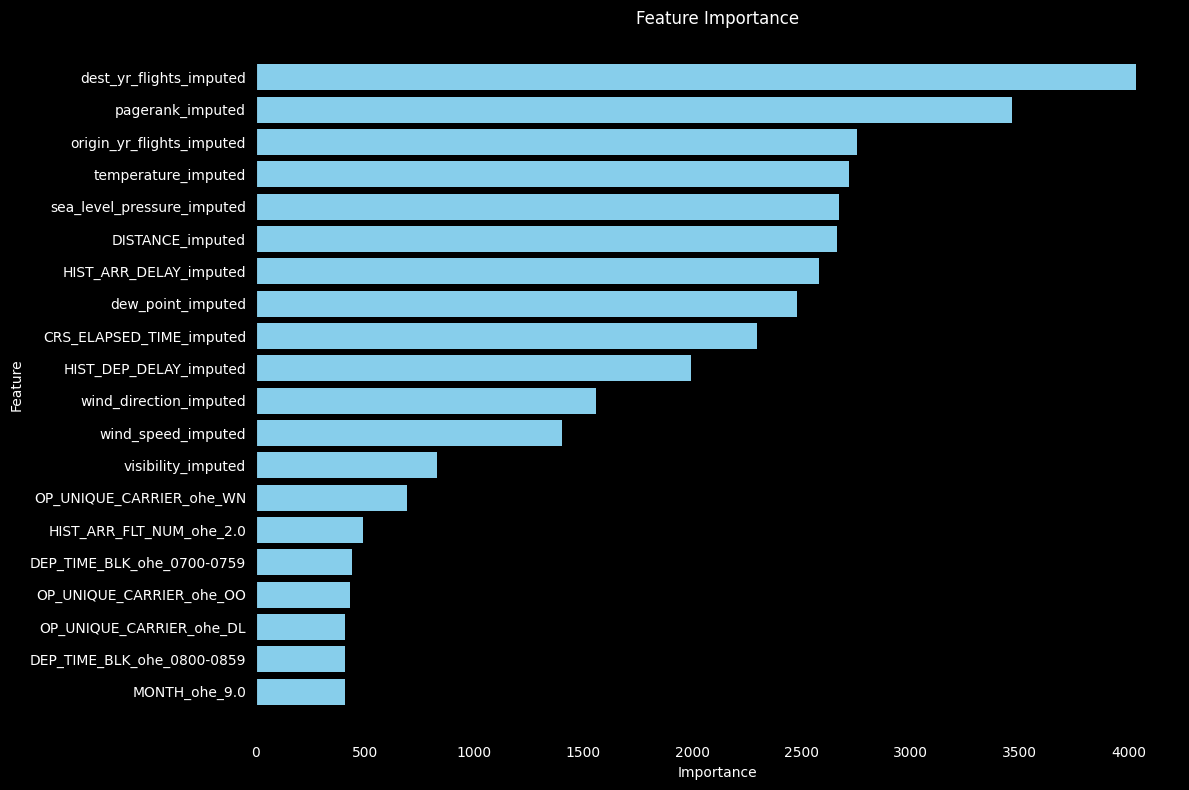

In [0]:
import matplotlib.pyplot as plt

# Optional: Display only the top N features
top_n = 20
sorted_features = importance_pairs[:top_n]

# Optional: Display only the top N features
top_n = 20
sorted_features = sorted_features[:top_n]

# Separate names and values for plotting
features, importances = zip(*sorted_features)

# Plot the data
plt.figure(figsize=(12, 8))

# Set the figure background and axes background to black
plt.rcParams['figure.facecolor'] = 'black'
plt.gca().set_facecolor('black')

# Plot the bar chart
plt.barh(features, importances, color='skyblue')

# Customize the labels and title with white text
plt.xlabel('Importance', color='white')
plt.ylabel('Feature', color='white')
plt.title('Feature Importance', color='white')

# Customize the ticks with white text
plt.xticks(color='white')
plt.yticks(color='white')

plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.tight_layout()
plt.show()

# Test set

In [0]:
def calculate_metrics(prediction, beta=0.5):
    tp = prediction.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
    fp = prediction.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
    fn = prediction.filter((col(label_col) == 1) & (col("prediction") == 0)).count()
    tn = prediction.filter((col(label_col) == 0) & (col("prediction") == 0)).count()

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F-beta score with beta=0.5
    beta = 0.5
    fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

    return fbeta, precision, recall

In [0]:
# Get the list of stages in the pipeline model
stages = pipeline_model.stages

# Display information about each stage
for i, stage in enumerate(stages):
    print(f"Stage {i}: {stage}")

Stage 0: ImputerModel: uid=Imputer_4d6ef536e77b, strategy=mean, missingValue=NaN, numInputCols=14, numOutputCols=14
Stage 1: StringIndexerModel: uid=StringIndexer_1c6678172f28, handleInvalid=keep
Stage 2: StringIndexerModel: uid=StringIndexer_10bd7808e10d, handleInvalid=keep
Stage 3: StringIndexerModel: uid=StringIndexer_507350ea3b7b, handleInvalid=keep
Stage 4: StringIndexerModel: uid=StringIndexer_32e390e80937, handleInvalid=keep
Stage 5: StringIndexerModel: uid=StringIndexer_ee6e5dc833be, handleInvalid=keep
Stage 6: StringIndexerModel: uid=StringIndexer_2c9227415811, handleInvalid=keep
Stage 7: StringIndexerModel: uid=StringIndexer_97c8b86b6c43, handleInvalid=keep
Stage 8: StringIndexerModel: uid=StringIndexer_5eead6269a04, handleInvalid=keep
Stage 9: StringIndexerModel: uid=StringIndexer_501eb8422c3e, handleInvalid=keep
Stage 10: StringIndexerModel: uid=StringIndexer_3033a12b03c6, handleInvalid=keep
Stage 11: StringIndexerModel: uid=StringIndexer_088d472e7722, handleInvalid=keep
St

In [0]:
test_5yr = spark.read.parquet(f'{team_blob_url}/data/5yr_test.parquet')

In [0]:
training_preds = pipeline_model.transform(filtered_df)
test_preds = pipeline_model.transform(test_5yr)

predictions = {"train": training_preds, "test": test_preds}

# Store metrics per key
train_test = []
# Calculate training and validation metrics
for key, prediction in predictions.items():
    fbeta, precision, recall = calculate_metrics(prediction)

    # Store metrics for this fold
    p_key = "precision_" + key
    r_key = "recall_" + key
    fb_key = "fbeta_" + key

    train_test.append({
        p_key: precision,
        r_key: recall,
        fb_key: fbeta
    })

metrics = train_test[0] | train_test[1]

print(metrics)

{'precision_train': 0.7824976433528668, 'recall_train': 0.6654847851348821, 'fbeta_train': 0.7559149851296881, 'precision_test': 0.19517724750223298, 'recall_test': 0.979216279254847, 'fbeta_test': 0.23239149934751854}
